# Data Science Research Methods Report-2

## **Introduction**<br>
The PAMAP2 Physical Activity Monitoring dataset (available here) contains data from 9 participants who participated in 18 various physical activities (such as walking, cycling, and soccer) while wearing three inertial measurement units (IMUs) and a heart rate monitor. This information is saved in separate text files for each subject. The goal is to build hardware and/or software that can determine the amount and type of physical activity performed by an individual by using insights derived from analysing the given dataset. 

In [2]:
import os
import pdb
from IPython.display import display
from matplotlib import rcParams
from scipy.stats import ranksums
import numpy as np
import seaborn as sns
os.chdir("/home/sahil/Downloads/PAMAP2_Dataset/Protocol")
import pandas as pd
import matplotlib.pyplot as plt

## Data Cleaning<br>
For tidying up the data :<br>
- We load the data of various subjects and give relevant column names<br>
  for various features. <br>
- The data for all subjects are then stacked together to form one table.<br>
- We remove the 'Orientation' columns because it was mentioned <br>
  in the data report that it is invalid in this data collection.<br>
- Similarly, the rows with Activity ID "0" are also removed as<br>
  it does not relate to any specific activity.<br>
- The missing values are filled up using the mean for that feature.


<br>
Given below are functions to give relevant names to the columns and create a<br>
single table containing data for all subjects<br>


In [3]:
def gen_activity_names():
    # Using this function all the activity names are mapped to their ids
    act_name = {}
    act_name[0] = 'transient'
    act_name[1] = 'lying'
    act_name[2] = 'sitting'
    act_name[3] = 'standing'
    act_name[4] = 'walking'
    act_name[5] = 'running'
    act_name[6] = 'cycling'
    act_name[7] = 'Nordic_walking'
    act_name[9] = 'watching_TV'
    act_name[10] = 'computer_work'
    act_name[11] = 'car driving'
    act_name[12] = 'ascending_stairs'
    act_name[13] = 'descending_stairs'
    act_name[16] = 'vacuum_cleaning'
    act_name[17] = 'ironing'
    act_name[18] = 'folding_laundry'
    act_name[19] = 'house_cleaning'
    act_name[20] = 'playing_soccer'
    act_name[24] = 'rope_jumping'
    return act_name
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]
def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]
def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output
def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output

In [4]:
def load_subjects(root1='/home/sahil/Downloads/PAMAP2_Dataset/Protocol/subject',
        root2 ='/home/sahil/Downloads/PAMAP2_Dataset/Optional/subject' ):
    cols = load_IMU()
    output = pd.DataFrame()
    for i in range(101,110):
        path1 = root1 + str(i) + '.dat'
        path2 = root2 + str(i) + '.dat'
        subject= pd.DataFrame()
         
        try: # exception handling in casethe file  doesnt exist
         subject_prot = pd.read_table(path1, header=None, sep='\s+') # subject data from 
         # protocol activities
         subject_opt = pd.read_table(path2, header=None, sep='\s+') # subject data from 
         # optional activities
         subject = subject.append(subject_prot)
         subject = subject.append(subject_opt)
         subject.columns = cols 
         subject = subject.sort_values(by='time_stamp') # Arranging all measurements according to
         # time
        except Exception as e:
         continue   # Continue to next iteration if file doesn't exist
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    return output
data = load_subjects()# Add your own location for the data here to replicate the code
# for eg data = load_subjects('filepath')
data = data.drop(data[data['activity_id']==0].index)# Removing rows with activity id of 0
act = gen_activity_names()
data['activity_name'] = data.activity_id.apply(lambda x:act[x])
data = data.drop([i for i in data.columns if 'orientation' in i],axis=1)# Dropping Orientation 
# columns
display(data.head())

time_stamp  activity_id  heart_rate  hand_temperature  \
5691       37.66            1         NaN            30.375   
5693       37.67            1         NaN            30.375   
5695       37.68            1         NaN            30.375   
5697       37.69            1         NaN            30.375   
5699       37.70            1       100.0            30.375   

      hand_3D_acceleration_16_x  hand_3D_acceleration_16_y  \
5691                    2.21530                    8.27915   
5693                    2.29196                    7.67288   
5695                    2.29090                    7.14240   
5697                    2.21800                    7.14365   
5699                    2.30106                    7.25857   

      hand_3D_acceleration_16_z  hand_3D_acceleration_6_x  \
5691                    5.58753                   2.24689   
5693                    5.74467                   2.27373   
5695                    5.82342                   2.26966   
5697                    5.89930                   2.22177   
5699                    6.09259                   2.20720   

      hand_3D_acceleration_6_y  hand_3D_acceleration_6_z  ...  \
5691                   8.55387                   5.77143  ...   
5693                   8.14592                   5.78739  ...   
5695                   7.66268                   5.78846  ...   
5697                   7.25535                   5.88000  ...   
5699                   7.24042                   5.95555  ...   

      ankle_3D_acceleration_6_y  ankle_3D_acceleration_6_z  \
5691                   -1.76757                   0.265761   
5693                   -1.75247                   0.250816   
5695                   -1.73721                   0.356632   
5697                   -1.78264                   0.311453   
5699                   -1.75240                   0.295902   

      ankle_3D_gyroscope_x  ankle_3D_gyroscope_y  ankle_3D_gyroscope_z  \
5691              0.002908             -0.027714              0.001752   
5693              0.020882              0.000945              0.006007   
5695             -0.035392             -0.052422             -0.004882   
5697             -0.032514             -0.018844              0.026950   
5699              0.001351             -0.048878             -0.006328   

      ankle_3D_magnetometer_x  ankle_3D_magnetometer_y  \
5691                 -61.1081                 -36.8636   
5693                 -60.8916                 -36.3197   
5695                 -60.3407                 -35.7842   
5697                 -60.7646                 -37.1028   
5699                 -60.2040                 -37.1225   

      ankle_3D_magnetometer_z   id  activity_name  
5691                 -58.3696  101          lying  
5693                 -58.3656  101          lying  
5695                 -58.6119  101          lying  
5697                 -57.8799  101          lying  
5699                 -57.8847  101          lying  

[5 rows x 44 columns]

**Note**: The procedure to replace missing values using the feature mean is performed<br>
after hypothesis testing and EDA as filling up the missing values would lead to us getting<br>
incorrect sample sizes for hypotheses testing. For Hypotheses testing the blank rows of an <br>
attribute will simply be ignored.

In [5]:
def clean_data(data): # Function for extracting clean data
    #data = data.interpolate()
    # fill all the NaN values in a column with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    return data

## Exploratory Data Analysis<br>
After labelling the data appropriately, it is randomly split into training and testing sets. <br>
In the training set, we perform Exploratory Data Analysis and come up with potential hypotheses. <br>
We then test those hypotheses on the testing set.<br>
50% of data is used for training in this case(Exploratory data analysis) and the rest for testing

In [6]:
def train_test_split(data,split_size):
    np.random.seed(5)
    msk = np.random.rand(len(data)) < split_size # This code implies 80% of the values will be True
    train = data[msk] # Generating training data
    test = data[~msk] # generating testing data  
    return train,test
train,test = train_test_split(data,0.50)

### Data Visualizations

* Boxplot of heart rate grouped by activity 

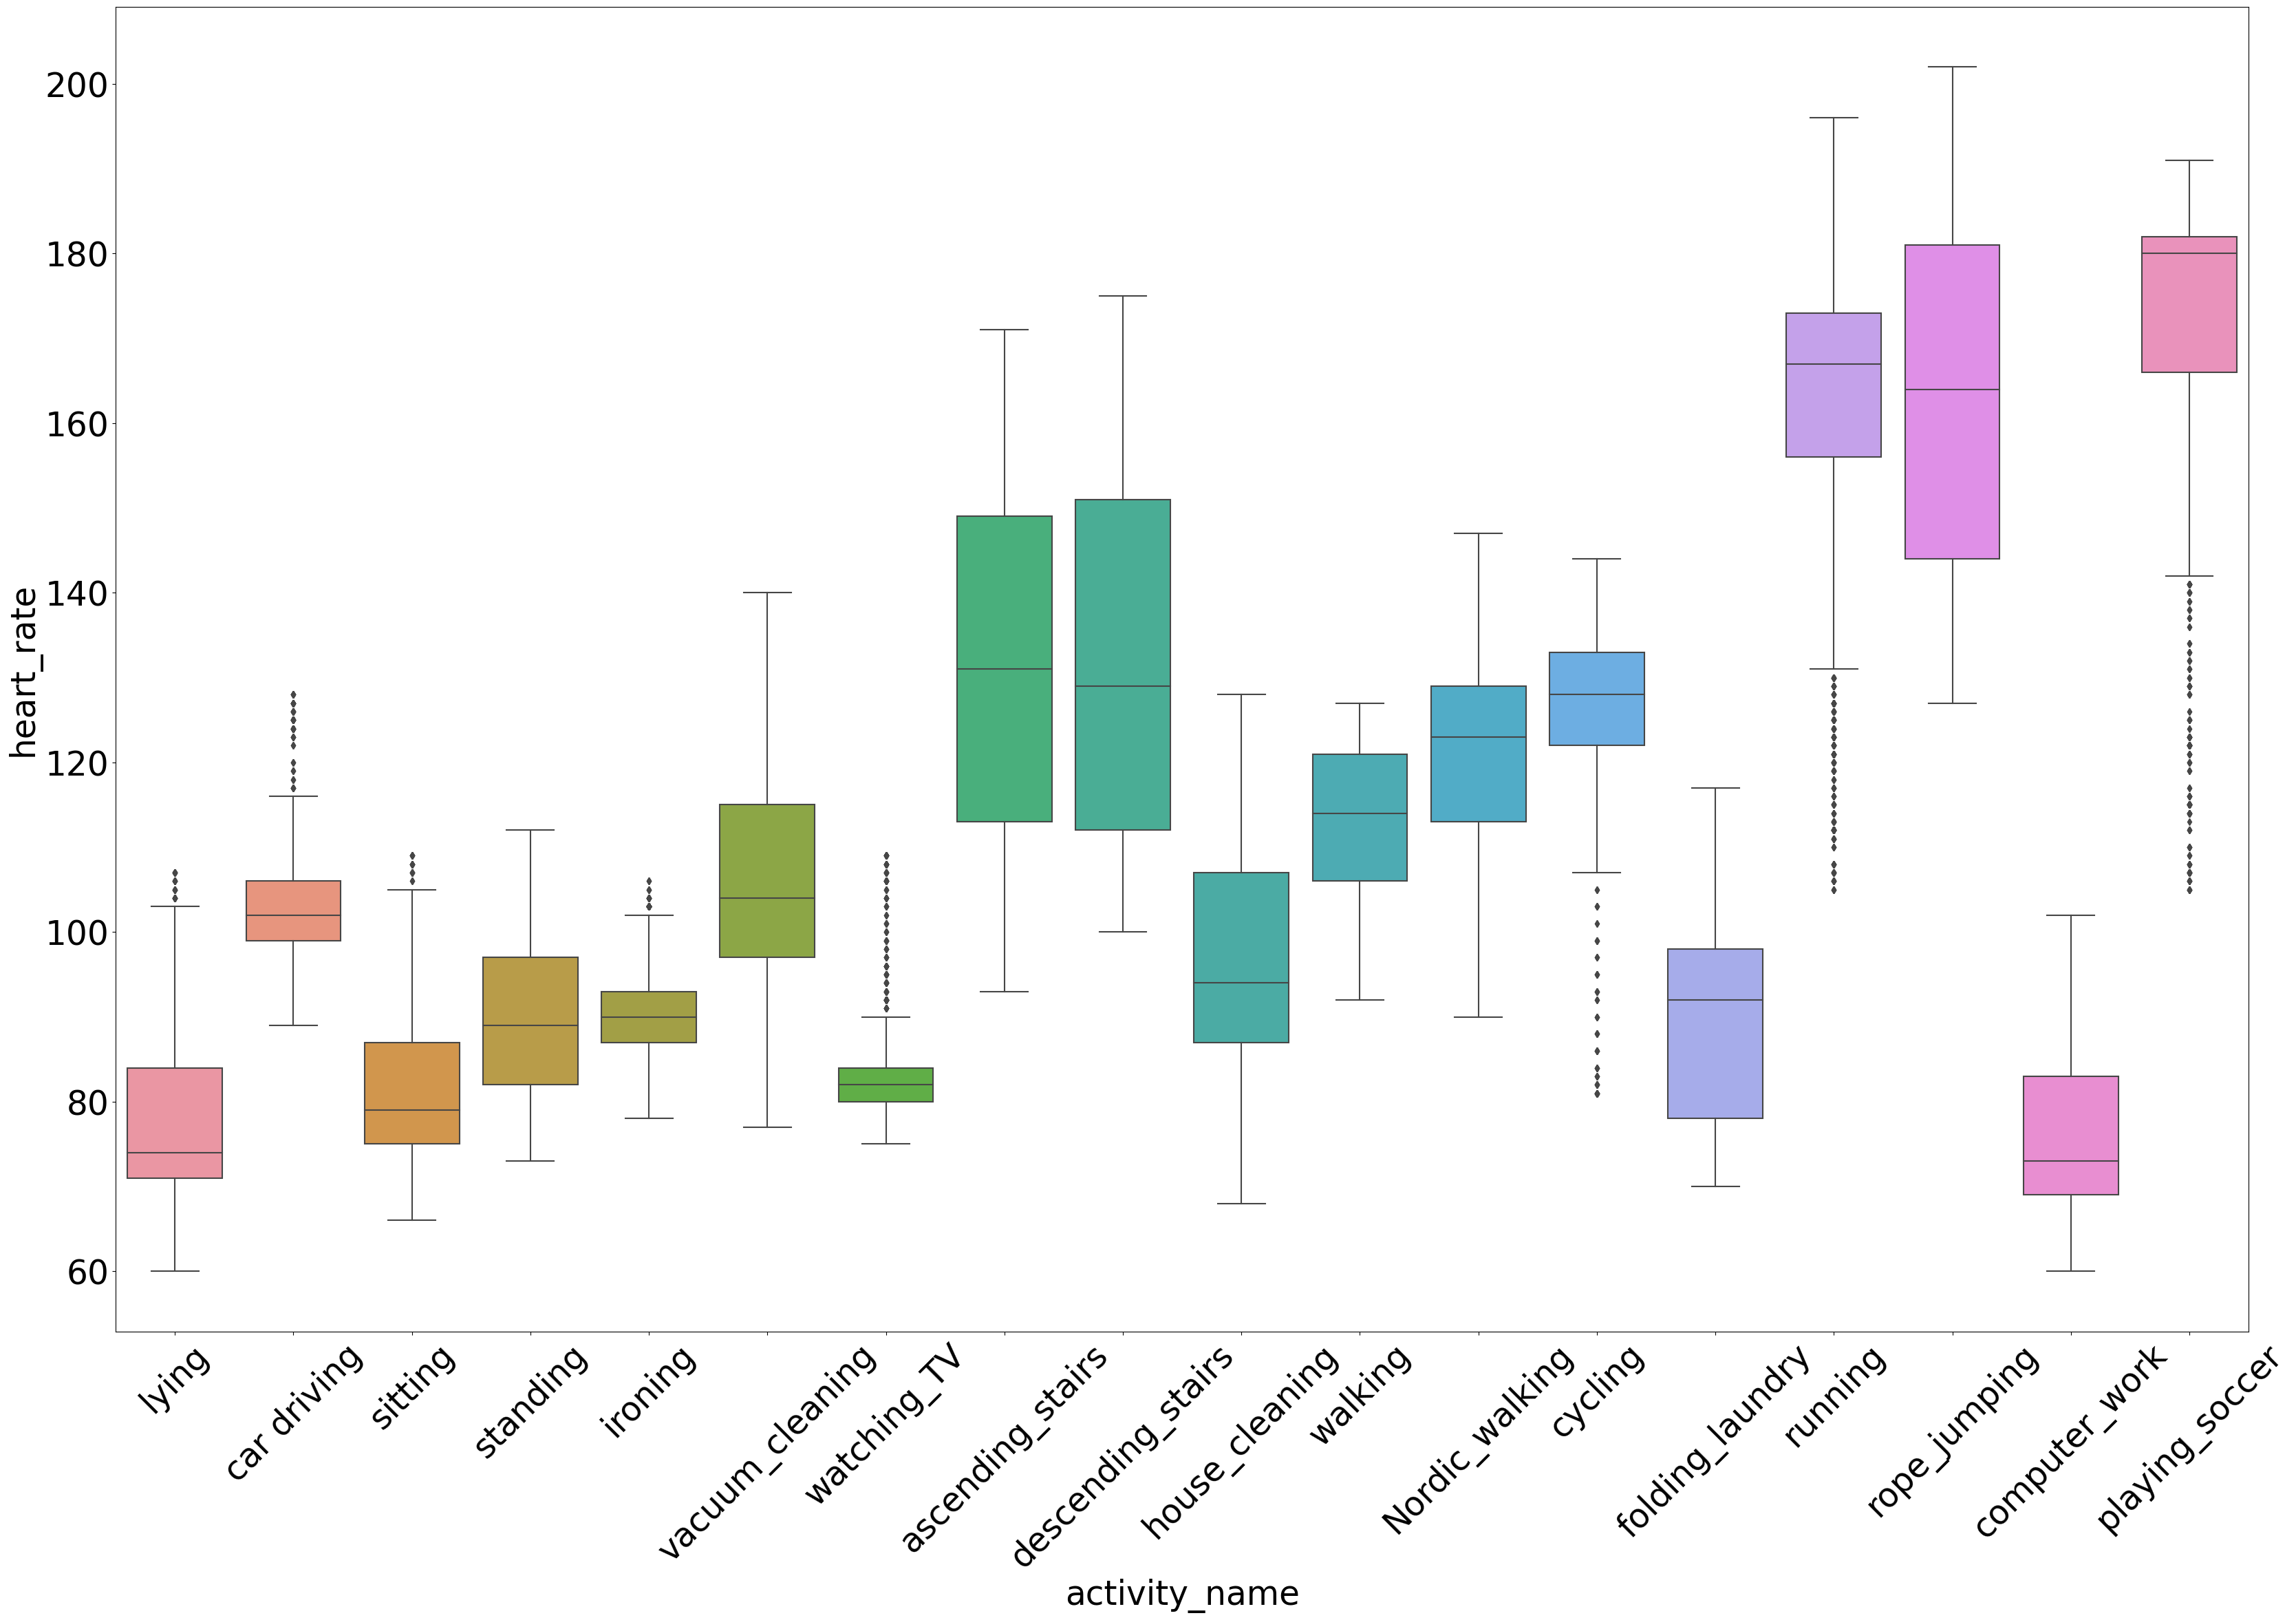

In [7]:
rcParams['figure.figsize'] = 40,25 # Setting the figure dimensions 
rcParams['font.size'] = 35 # Setting the text and number font size
ax=sns.boxplot(x="activity_name",y="heart_rate",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

  1. From the boxplot we can notice that activities like running and rope jumping have higher average heart rate than other activities<br>
  2. 'Nordic_walking' and 'running' have a lot of outliers on the lower side<br>
  3.  Activities like 'lying','sitting' and standing have a lot of outliers on the upper side.

* Boxplot of hand temperature grouped by activity

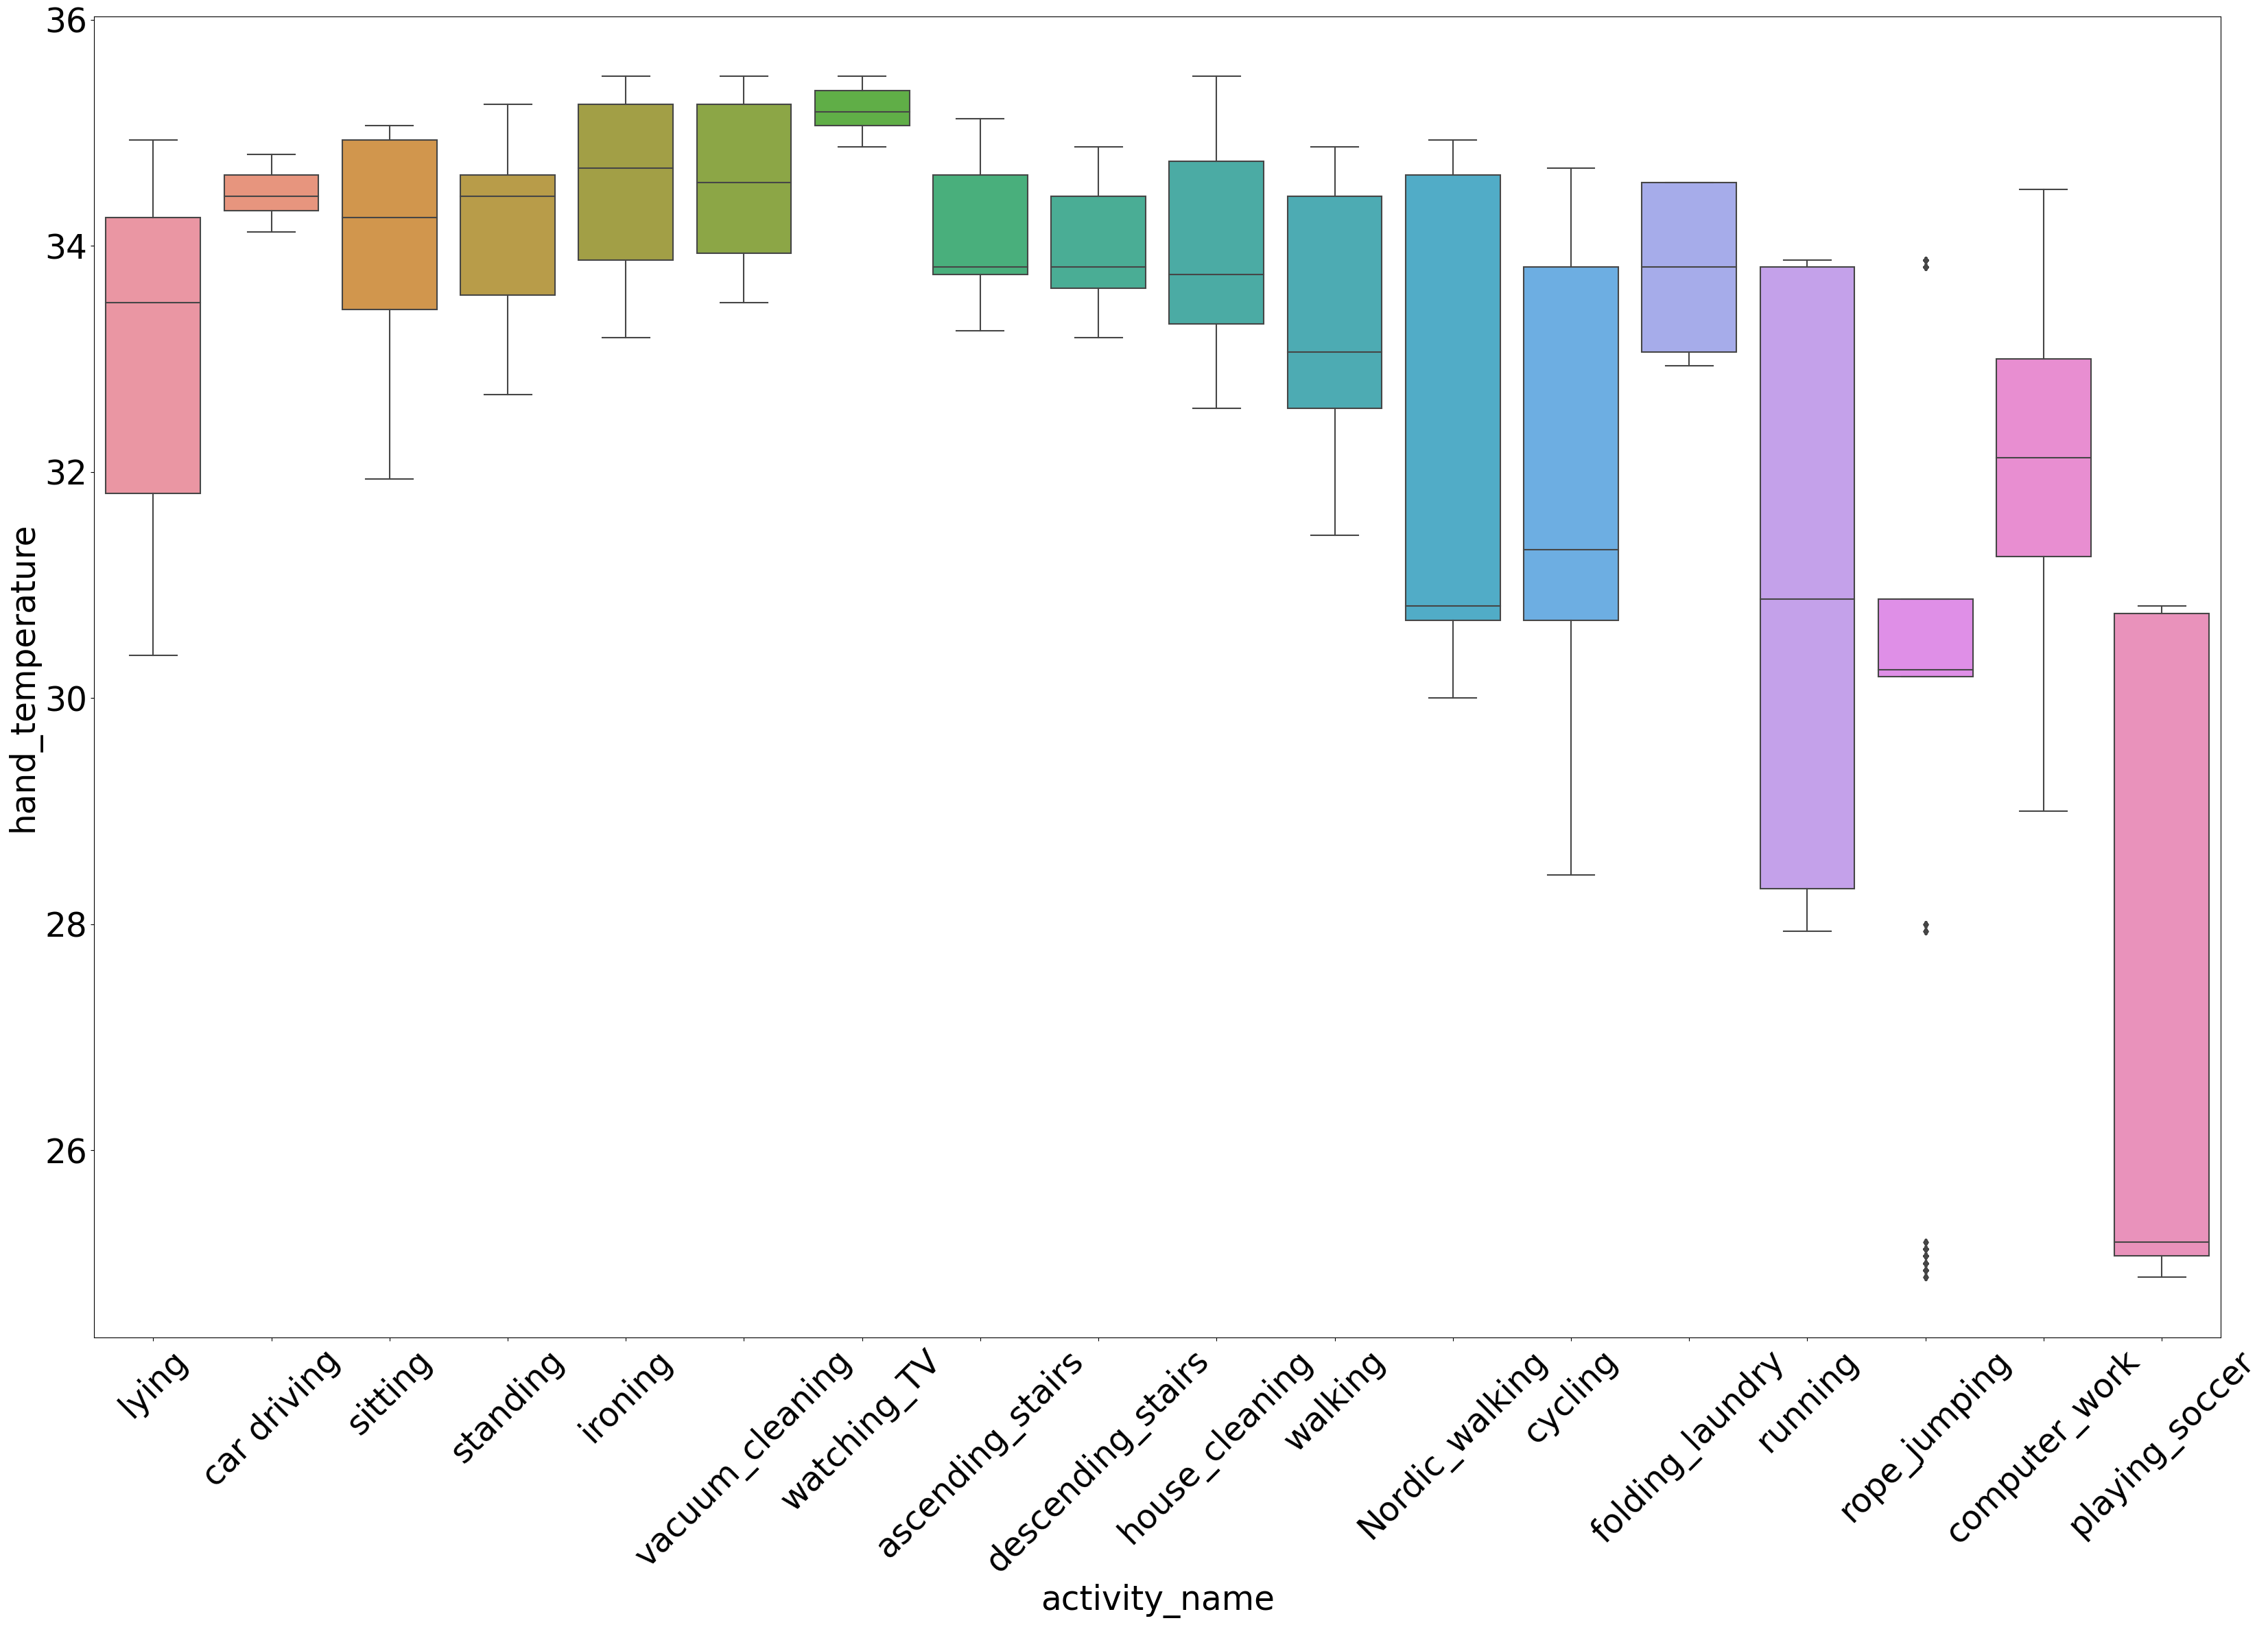

In [8]:
ax=sns.boxplot(x="activity_name",y="hand_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)# Rotating Text
plt.show()

1. "Ironing" and "vacuum_cleaning" may have higher average hand temperatures compared to other activitiies.<br>
2. "Lying" and "standing" have outliers on the upper side while "ascending_stairs" has it on the lower side.

* Boxplot of ankle temperature grouped by activity

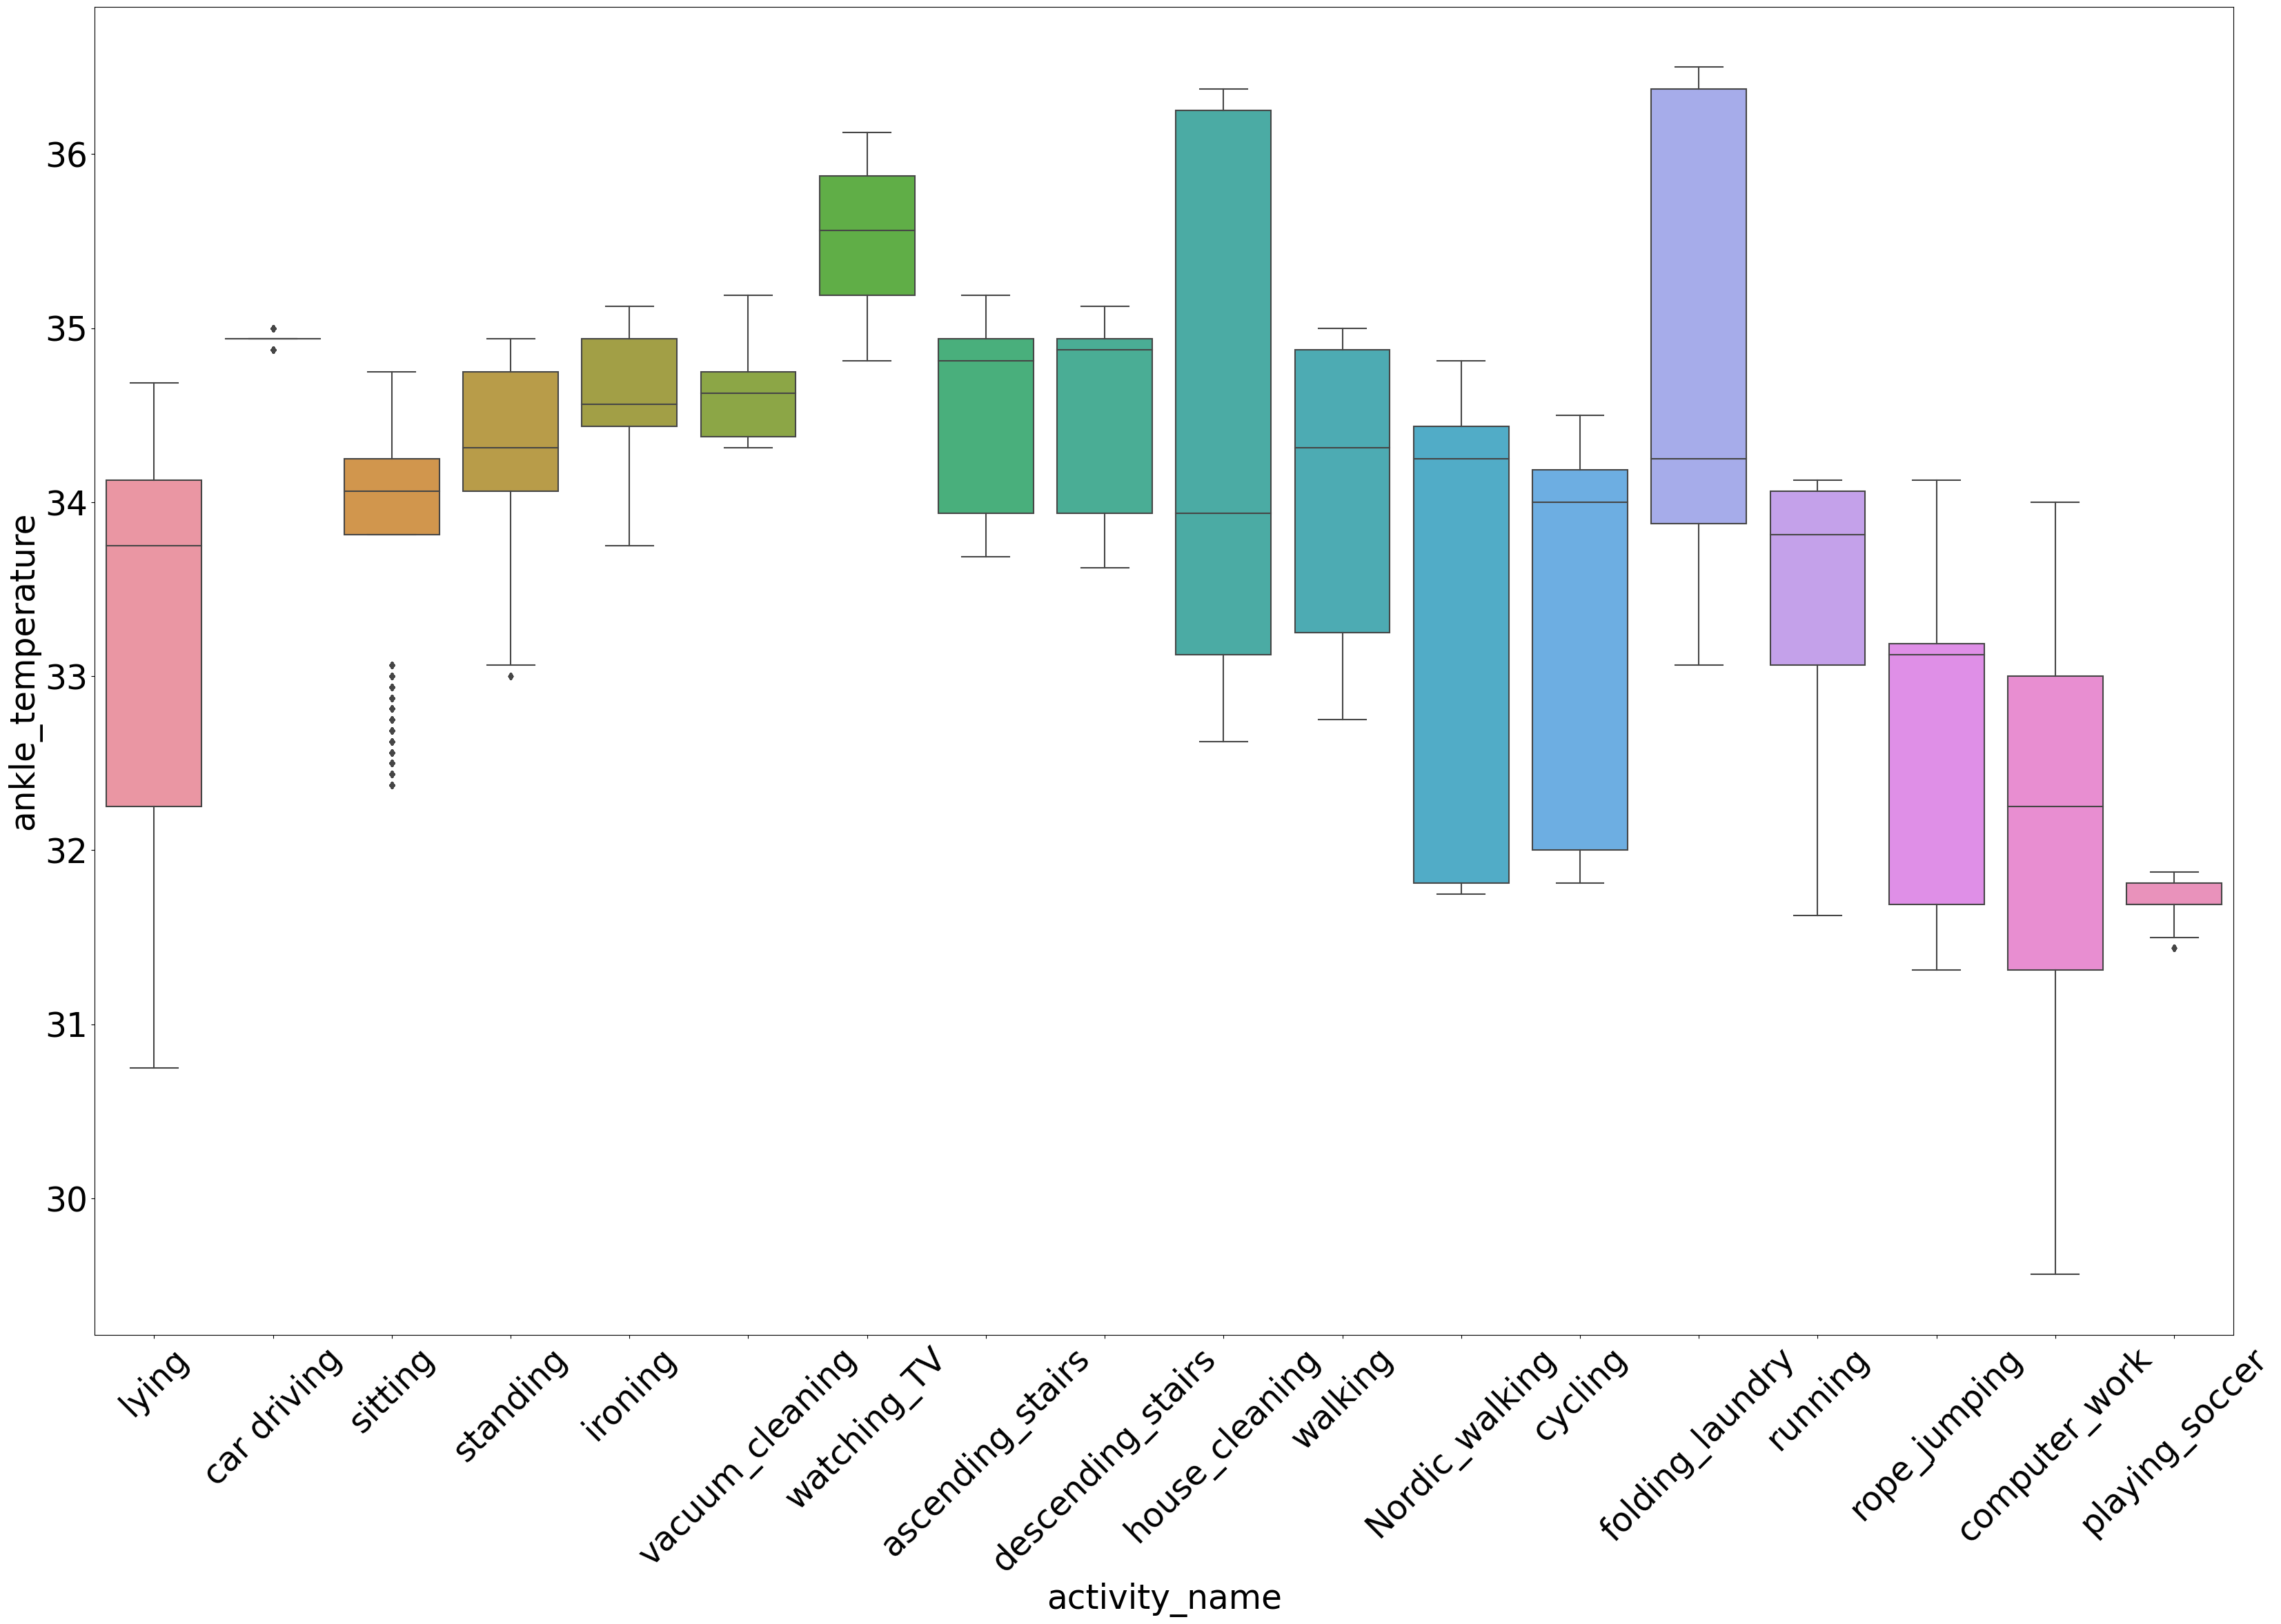

In [9]:
ax=sns.boxplot(x="activity_name",y="ankle_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. Interestingly, we see that "ankle_temperature" might be lower on average while lying.<br>
2. Outliers are mostly present in "rope_jumping" and "vacuum_cleaning" on the lower side. 

* Boxplot of chest temperature grouped by activity.

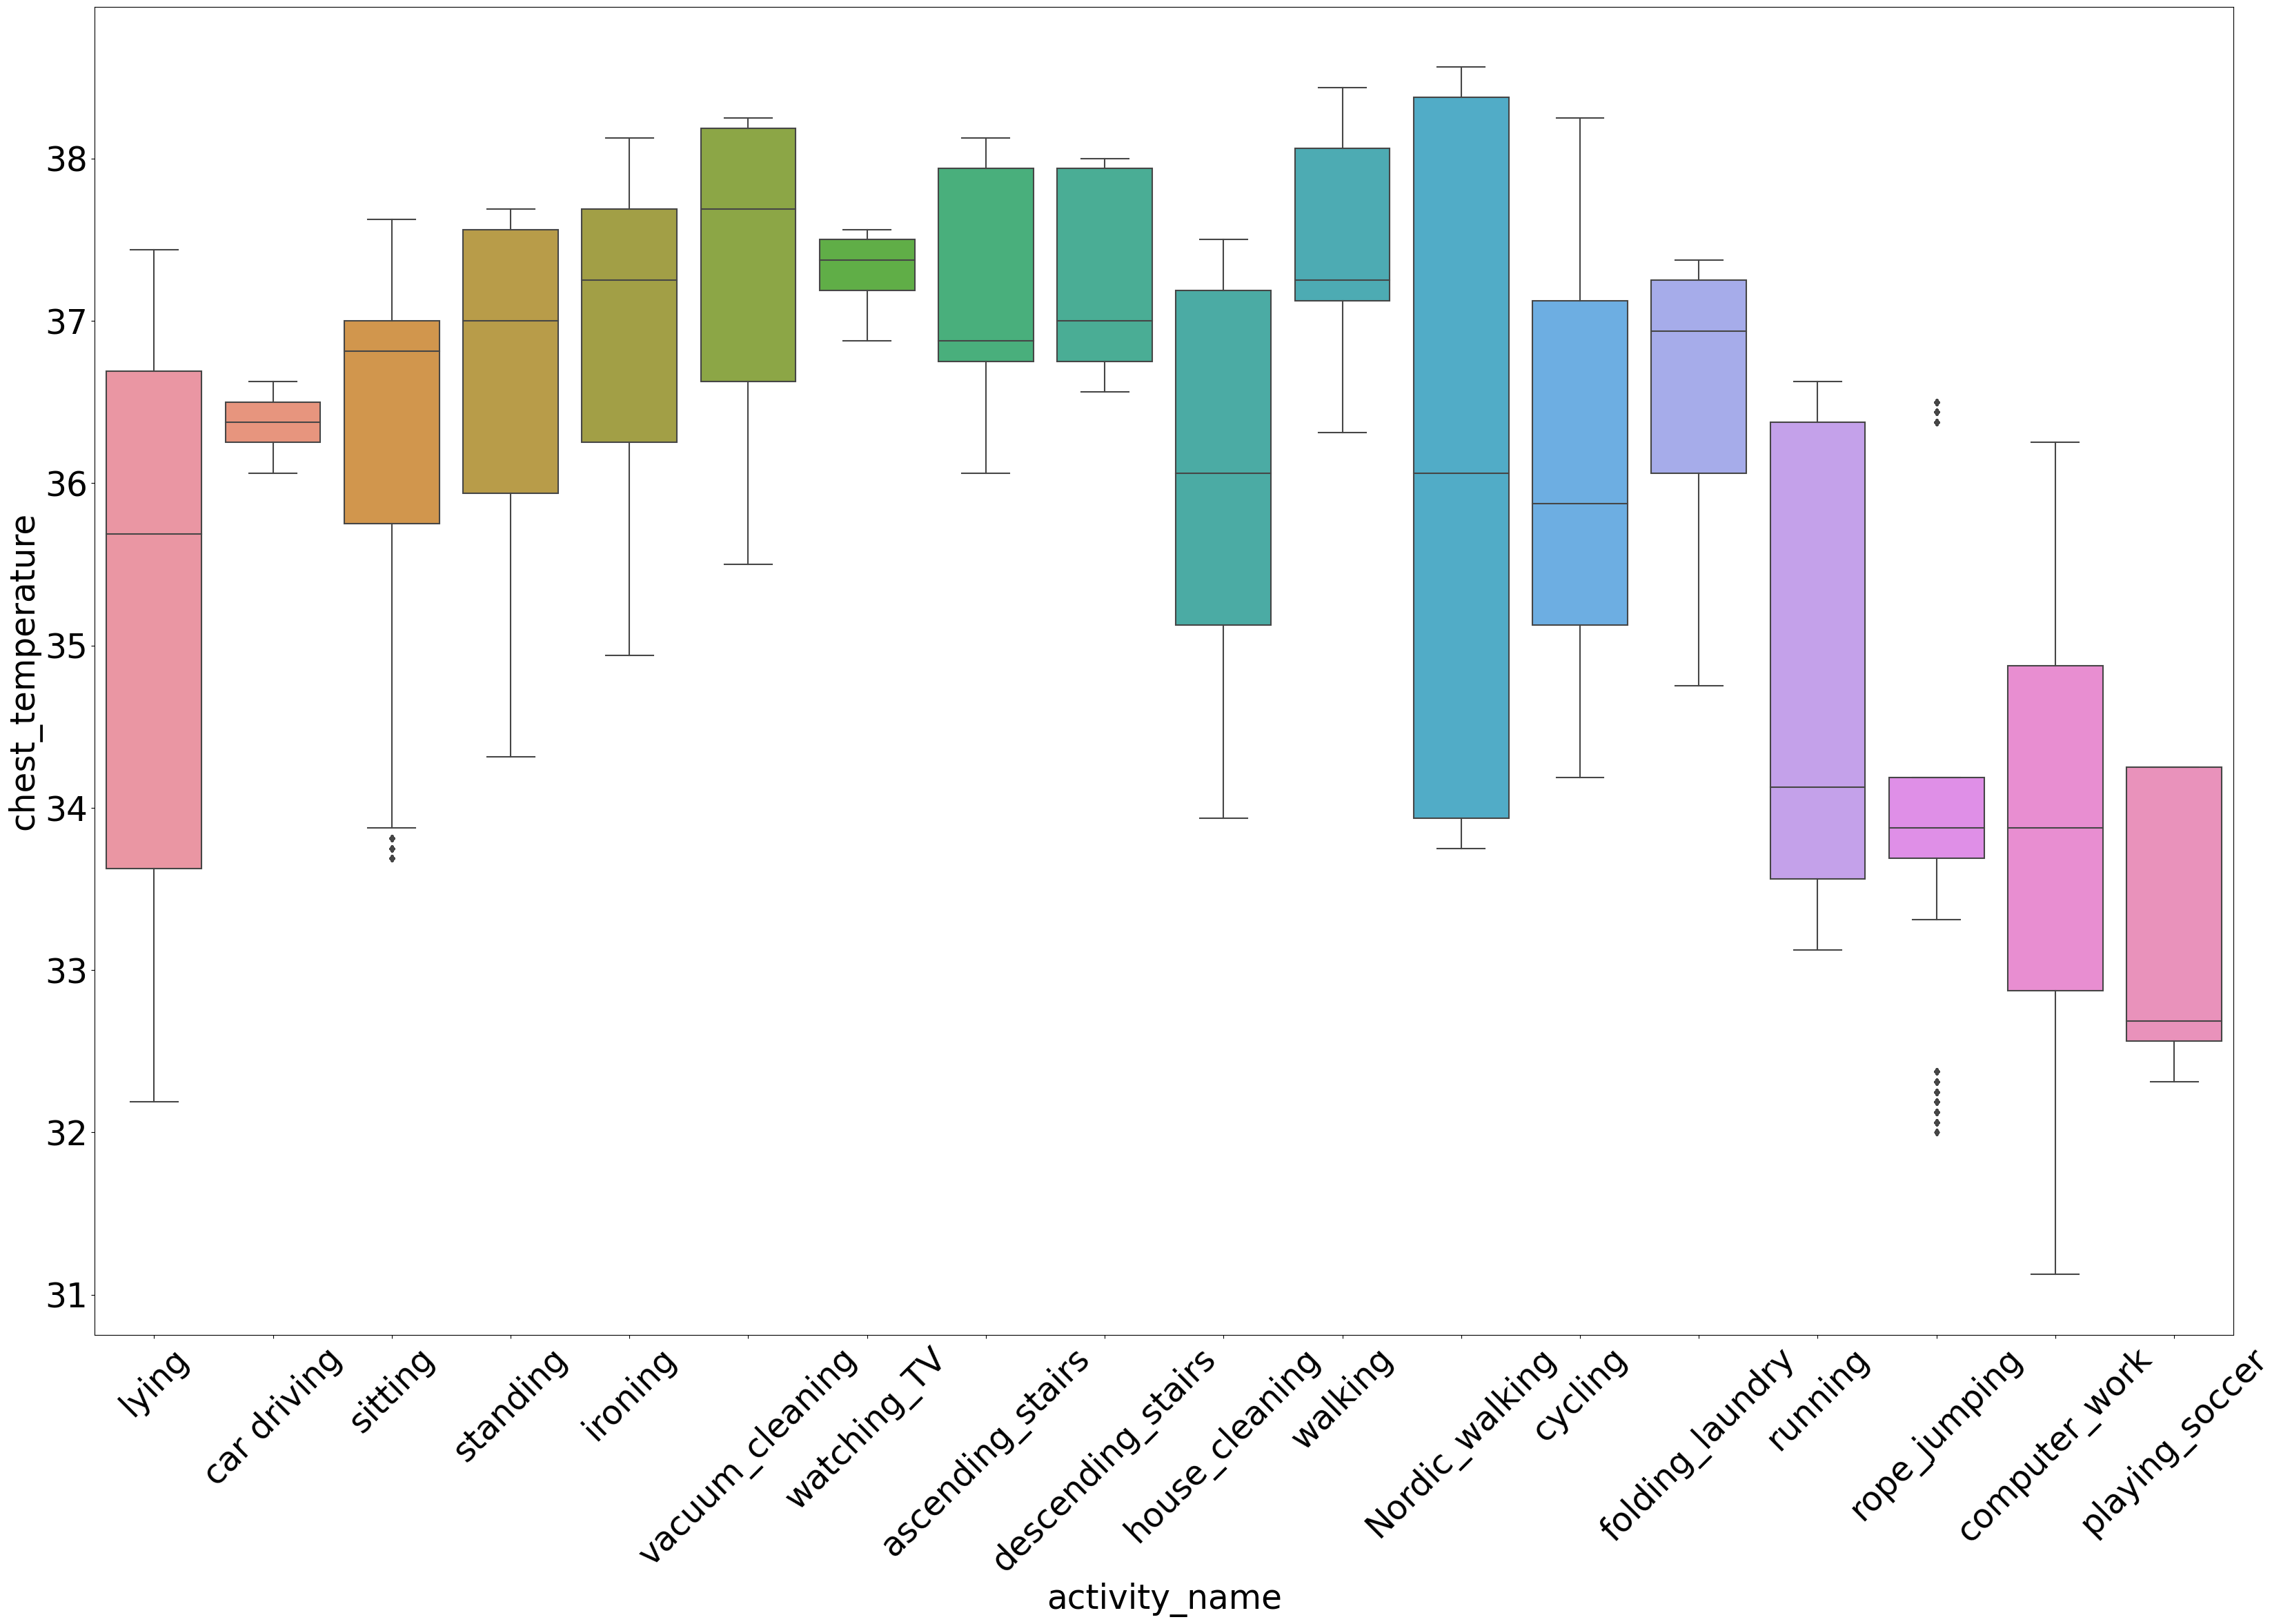

In [10]:
ax=sns.boxplot(x="activity_name",y="chest_temperature",data=train)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. Just like ankle temperature, the mean of chest temperature seems to be lower while lying  <br>
   and even "running" seems to have lower average, although the data is more widely distributed and positively skewed.<br>
2. The outliers are only present in "lying" and they are on the higher side.

* A joint plot trying to investigate possibility of correlation between heart rate <br>
  and chest temperature.

<Figure size 4000x2500 with 0 Axes>

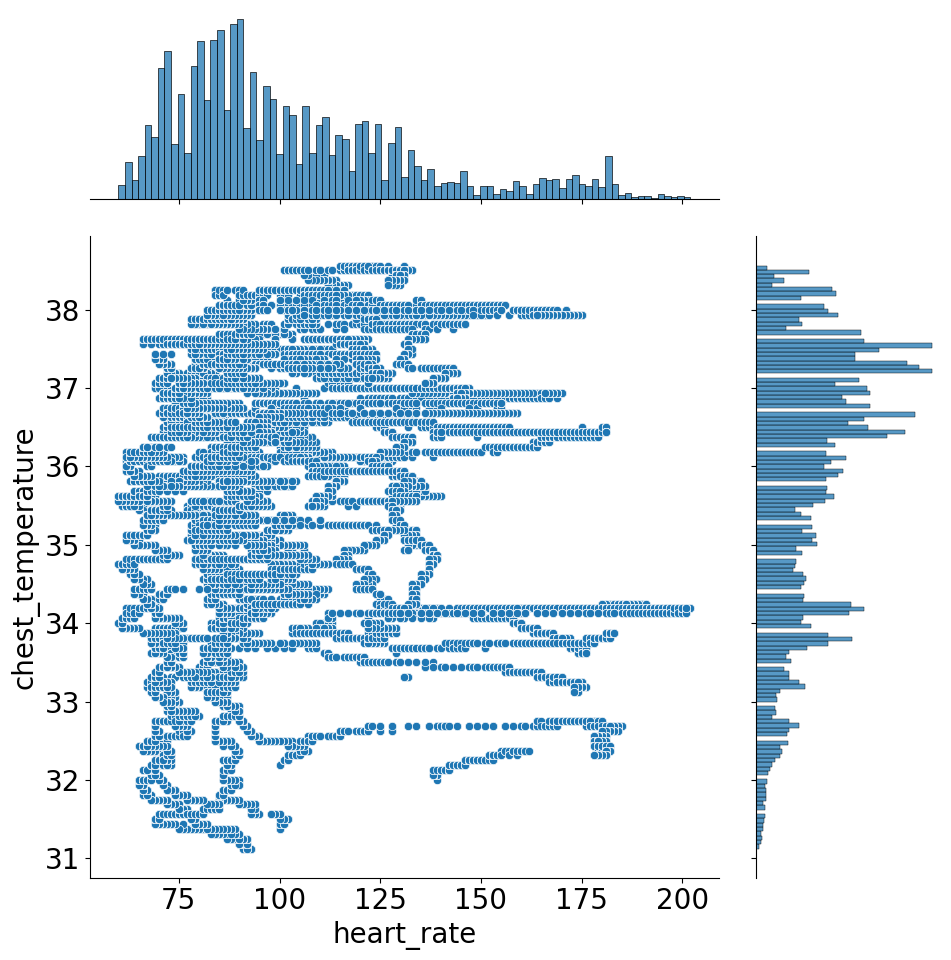

In [11]:
plt.clf()
rcParams['font.size'] = 20 # Setting the text and number font size
g = sns.JointGrid(data=train, x="heart_rate", y="chest_temperature",
                  height=10,ratio=3)
g.plot_joint(sns.scatterplot,palette='colorblind')
g.plot_marginals(sns.histplot)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45) # Rotating Text
plt.show()

1. From the scatter plot, we see that there does not seem to be a correlation between<br>
   the two variables.<br>
2. The respective histograms indicate that both the features considered have <br>
   a multi-modal distribution.

### Decriptive Statistics<br>
Mean of heart rate and temperatures for each activity

In [12]:
display(train.groupby(by='activity_name')[['heart_rate','chest_temperature','hand_temperature',
    'ankle_temperature']].mean())
discard = ['activity_id','activity','time_stamp','id']# Columns to exclude from descriptive statistics

heart_rate  chest_temperature  hand_temperature  \
activity_name                                                        
Nordic_walking     122.732659          36.165534         32.028178   
ascending_stairs   130.934169          37.250100         34.078969   
car driving        103.179352          36.369624         34.484215   
computer_work       75.706476          33.848345         32.118054   
cycling            126.408273          36.079906         31.597702   
descending_stairs  132.982625          37.305476         33.973817   
folding_laundry     90.404004          36.458630         33.666535   
house_cleaning      96.633393          36.039296         34.024252   
ironing             90.653986          36.815793         34.402746   
lying               77.487989          35.475480         33.315886   
playing_soccer     168.313488          33.209115         27.265352   
rope_jumping       163.280518          34.149276         30.177488   
running            160.758355          34.524003         30.963264   
sitting             81.120159          36.113473         33.812217   
standing            89.875880          36.357122         34.079367   
vacuum_cleaning    107.961289          37.096953         34.450429   
walking            112.357414          37.399058         33.240509   
watching_TV         83.473454          37.336655         35.197986   

                   ankle_temperature  
activity_name                         
Nordic_walking             33.662957  
ascending_stairs           34.517764  
car driving                34.936911  
computer_work              32.111387  
cycling                    33.495579  
descending_stairs          34.459465  
folding_laundry            34.587270  
house_cleaning             34.303197  
ironing                    34.589068  
lying                      33.413063  
playing_soccer             31.723000  
rope_jumping               32.670950  
running                    33.321737  
sitting                    33.881575  
standing                   34.202434  
vacuum_cleaning            34.671386  
walking                    34.119212  
watching_TV                35.520634

Creating table with only relevant columns

In [13]:
train_trimmed = train[[i for i in train.columns if i not in discard]]

Descriptive info of relevant feature

In [14]:
display(train_trimmed.describe())

heart_rate  hand_temperature  hand_3D_acceleration_16_x  \
count  82984.000000     908824.000000              908824.000000   
mean     102.445833         33.074329                  -2.987270   
std       28.926663          1.970794                   6.532813   
min       60.000000         24.875000                -154.609000   
25%       82.000000         32.125000                  -7.451243   
50%       94.000000         33.562500                  -2.034020   
75%      118.000000         34.562500                   0.870396   
max      202.000000         35.500000                 106.034000   

       hand_3D_acceleration_16_y  hand_3D_acceleration_16_z  \
count              908824.000000              908824.000000   
mean                    3.349812                   4.124108   
std                     7.437034                   4.387180   
min                  -104.301000                -101.452000   
25%                     0.061194                   1.449038   
50%                     3.511820                   4.214470   
75%                     7.347040                   7.311100   
max                   157.611000                 155.737000   

       hand_3D_acceleration_6_x  hand_3D_acceleration_6_y  \
count             908824.000000             908824.000000   
mean                  -2.900150                  3.326685   
std                    6.537110                  7.198150   
min                  -61.366100                -61.876400   
25%                   -7.306802                  0.075729   
50%                   -1.893470                  3.538480   
75%                    0.991575                  7.371033   
max                   62.372400                 62.252400   

       hand_3D_acceleration_6_z  hand_3D_gyroscope_x  hand_3D_gyroscope_y  \
count             908824.000000        908824.000000        908824.000000   
mean                   4.330354            -0.002876             0.044777   
std                    4.378098             1.308761             0.974849   
min                  -61.934700           -28.135400           -17.849500   
25%                    1.678170            -0.286740            -0.143743   
50%                    4.473750            -0.006215             0.004136   
75%                    7.526217             0.247630             0.186986   
max                   60.487700            23.865200            23.077900   

       ...  ankle_3D_acceleration_16_z  ankle_3D_acceleration_6_x  \
count  ...               908345.000000              908345.000000   
mean   ...                   -3.089565                   8.849722   
std    ...                    3.934469                   5.697843   
min    ...                 -159.114000                 -61.183400   
25%    ...                   -4.012030                   7.868780   
50%    ...                   -2.727010                   9.430990   
75%    ...                   -1.538380                   9.783160   
max    ...                  160.343000                  62.099600   

       ankle_3D_acceleration_6_y  ankle_3D_acceleration_6_z  \
count              908345.000000              908345.000000   
mean                   -0.128022                  -2.653824   
std                     6.560061                   3.422441   
min                   -61.916400                 -62.364000   
25%                    -2.419680                  -3.602410   
50%                    -0.074395                  -2.299090   
75%                     2.084490                  -1.076890   
max                    62.055800                  61.439800   

       ankle_3D_gyroscope_x  ankle_3D_gyroscope_y  ankle_3D_gyroscope_z  \
count         908345.000000         908345.000000         908345.000000   
mean               0.011189             -0.012191              0.007289   
std                1.032198              0.579046              1.739704   
min              -29.077500            -14.228900            -16.474200   
25%               -

Correlation table of relevant features

In [15]:
display(train_trimmed.corr()) 

heart_rate  hand_temperature  \
heart_rate                    1.000000         -0.367977   
hand_temperature             -0.367977          1.000000   
hand_3D_acceleration_16_x    -0.401148          0.070590   
hand_3D_acceleration_16_y     0.055200          0.012308   
hand_3D_acceleration_16_z    -0.345017          0.027942   
hand_3D_acceleration_6_x     -0.409464          0.083074   
hand_3D_acceleration_6_y      0.051338          0.019123   
hand_3D_acceleration_6_z     -0.351296          0.044272   
hand_3D_gyroscope_x           0.001521         -0.006038   
hand_3D_gyroscope_y           0.070248         -0.036265   
hand_3D_gyroscope_z           0.001396         -0.005798   
hand_3D_magnetometer_x        0.366714         -0.067504   
hand_3D_magnetometer_y        0.029477         -0.058752   
hand_3D_magnetometer_z        0.255767          0.072971   
chest_temperature            -0.025278          0.773181   
chest_3D_acceleration_16_x   -0.019647          0.025448   
chest_3D_acceleration_16_y    0.104178         -0.025301   
chest_3D_acceleration_16_z   -0.279779          0.143906   
chest_3D_acceleration_6_x    -0.024275          0.039021   
chest_3D_acceleration_6_y     0.105574         -0.027041   
chest_3D_acceleration_6_z    -0.283413          0.154784   
chest_3D_gyroscope_x          0.005161          0.001745   
chest_3D_gyroscope_y          0.024310         -0.036844   
chest_3D_gyroscope_z         -0.033267          0.036057   
chest_3D_magnetometer_x      -0.016778         -0.030973   
chest_3D_magnetometer_y      -0.198282          0.056272   
chest_3D_magnetometer_z       0.290773         -0.146487   
ankle_temperature             0.001146          0.657872   
ankle_3D_acceleration_16_x    0.259480         -0.177132   
ankle_3D_acceleration_16_y    0.097449         -0.082787   
ankle_3D_acceleration_16_z    0.022572         -0.076029   
ankle_3D_acceleration_6_x     0.283715         -0.183908   
ankle_3D_acceleration_6_y     0.108467         -0.089678   
ankle_3D_acceleration_6_z     0.025162         -0.082613   
ankle_3D_gyroscope_x          0.017492         -0.020997   
ankle_3D_gyroscope_y         -0.009408         -0.001210   
ankle_3D_gyroscope_z          0.005452          0.000791   
ankle_3D_magnetometer_x      -0.259375          0.149422   
ankle_3D_magnetometer_y      -0.159600          0.166369   
ankle_3D_magnetometer_z      -0.114287          0.128449   

                            hand_3D_acceleration_16_x  \
heart_rate                                  -0.401148   
hand_temperature                             0.070590   
hand_3D_acceleration_16_x                    1.000000   
hand_3D_acceleration_16_y                   -0.052110   
hand_3D_acceleration_16_z                    0.256852   
hand_3D_acceleration_6_x                     0.981522   
hand_3D_acceleration_6_y                    -0.040059   
hand_3D_acceleration_6_z                     0.263928   
hand_3D_gyroscope_x                          0.006629   
hand_3D_gyroscope_y                         -0.137218   
hand_3D_gyroscope_z                          0.021472   
hand_3D_magnetometer_x                      -0.513383   
hand_3D_magnetometer_y                      -0.073007   
hand_3D_magnetometer_z                      -0.160935   
chest_temperature                           -0.189780   
chest_3D_acceleration_16_x                   0.017718   
chest_3D_acceleration_16_y                  -0.296659   
chest_3D_acceleration_16_z                   0.394798   
chest_3D_acceleration_6_x                    0.015481   
chest_3D_acceleration_6_y                   -0.300717   
chest_3D_acceleration_6_z                    0.394178   
chest_3D_gyroscope_x                        -0.078394   
chest_3D_gyroscope_y                        -0.042391   
chest_3D_gyroscope_z                         0.093846   
chest_3D_magnetometer_x                      0.078392   
chest_3D_magnetometer_y                      0.126078   
chest_3D_magnetometer_z     

## Hypothesis Testing  

Based on the exploratory data analysis carried out, the following hypotheses are tested on  <br>
the test set:<br>
- Hand temperature is higher during 'ironing' and 'vacuum_cleaning' compared<br>
  to other activities.<br>
- Ankle temperature is lower than other activities while lying.<br>
- Chest temperature is lower while lying compared to other activities. 

Based on the EDA  we performed, it does not seem that the data is normally distributed. It is <br>
for this reason that Wilcoxon rank sum test was used to test the above hypothesis instead of the usual t-test which assumes that the samples follow a normal distribution.<br>
We test the above hypothesis using the confidence level of 5%.

$H_0$(Null) : The hand temperature while ironing and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The hand temperature while ironing is likely to be higher compared to other activities.

In [16]:
test1 = test[test.activity_name=='ironing'].hand_temperature.dropna()# Hand temperature while ironing
test2 = test[test.activity_name!='ironing'].hand_temperature.dropna()# hand temperature while not ironing.Nan values dropped to get the actual size of samples.
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=206.9598714941324, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

$H_0$(Null) : The hand temperature while 'vacuum_cleaning' and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The hand temperature while 'vacuum_cleaning' is likely to be higher compared to other activities.

In [17]:
test1 = test[test.activity_name=='vacuum_cleaning'].hand_temperature.dropna()
test2 = test[test.activity_name!='vacuum_cleaning'].hand_temperature.dropna()
print(ranksums(test1,test2,alternative='greater'))

RanksumsResult(statistic=180.01703434067085, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

$H_0$(Null) : The ankle temperature while lying and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The ankle temperature while lying is likely to be lower compared to other activities.

In [18]:
test1 = test[test.activity_name=='lying'].ankle_temperature.dropna()
test2 = test[test.activity_name!='lying'].ankle_temperature.dropna()
print(ranksums(test1,test2,alternative='less'))

RanksumsResult(statistic=-69.67005740003434, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 

$H_0$(Null) : The chest temperature while lying and while doing other activities are not significantly  different.<br>
$H_1$(Alternate) : The chest temperature while lying is likely to be lower compared to other activities.

In [19]:
test1 = test[test.activity_name=='lying'].chest_temperature.dropna()
test2 = test[test.activity_name!='lying'].chest_temperature.dropna()
print(ranksums(test1,test2,alternative='less'))

RanksumsResult(statistic=-59.9420555461927, pvalue=0.0)


Since we get a p-value of 0 which is lower than 0.05 we reject the null hypothesis and accept<br>
the alternate hypothesis. 